In [19]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

from sksurv.column import encode_categorical
from sksurv.column import standardize
from sksurv.util import Surv

from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis


In [20]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

def evaluate_model_uno_c(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    return uno_concordance

In [21]:
pickle_file = 'data/DATA_DECEASED_ex.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)


In [45]:
dataset.shape

(117536, 20)

In [22]:
numeric_features = [
    "AGE",
    "KDPI",
    "DIALYSIS_TIME",
    "AGE_DON",
    "BMI_CALC",
    "CREAT_TRR",
    "NPKID",
    "COLD_ISCH_KI",
]
categorical_features = [
    "ON_DIALYSIS",
    "DIAB",
    "HCV_SEROSTATUS",
    "PRE_TX_TXFUS",
    "GENDER",
    "ETHCAT",
    "DIABETES_DON",
]


In [23]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Set up the final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Apply preprocessing to X
# X = pipeline.fit_transform(dataset[categorical_features + numeric_features ])

categorical_x = encode_categorical(dataset[categorical_features])
numerical_x = standardize(dataset[numeric_features])
X = pd.concat([numerical_x, categorical_x], axis=1)

survival_time = dataset["PTIME"].astype(np.float64)
event = dataset["PSTATUS"].astype(float).astype(bool)

y = Surv.from_arrays(event, survival_time, "Status", "Days")

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)

In [25]:
X_train.shape

(94028, 24)

In [35]:
def evaluate_model(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    surv_fn = model.predict_survival_function(test_X, return_array=False)
    surv_prob = np.row_stack([fn(times) for fn in surv_fn])

    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    ibs = integrated_brier_score(train_y, test_y, surv_prob, times)
    auc, mean_auc = cumulative_dynamic_auc(train_y, test_y, pred, times)

    print(f"Concordance Uno: {round(uno_concordance[0], 3)}")
    print(f"IBS: {round(ibs, 3)}")
    print(f"Mean AUC: {round(mean_auc,3)}")

    return uno_concordance, ibs, mean_auc

In [27]:
lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

# GBSA

In [29]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

class EarlyStoppingMonitor:
    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.2, subsample=0.5, max_depth=4, random_state=0, verbose=1
)

monitor = EarlyStoppingMonitor(25, 50)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 3))
# 10 iterations: 25m

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      224729.1269         660.1823         1854.24m
         2      223606.9607         563.5543         1887.25m
         3      223677.0610         475.2760         1892.78m
         4      223097.6554         397.1756         1892.06m
         5      224104.7566         333.0812         1894.01m
         6      222668.2373         282.4238         1897.70m
         7      222383.9641         241.6566         1895.87m
         8      221774.3496         209.2254         1898.18m
         9      222681.5692         184.0411         1898.32m
        10      221641.6582         164.6066         1898.20m
        20      219605.2394          57.8669         1878.72m
        30      220754.4951          23.6926         1859.51m
        40      220529.3550          14.4078         1842.49m
        50      219089.6312           9.1381         1822.08m
        60      220429.9443           3.7810         1804.67m
       

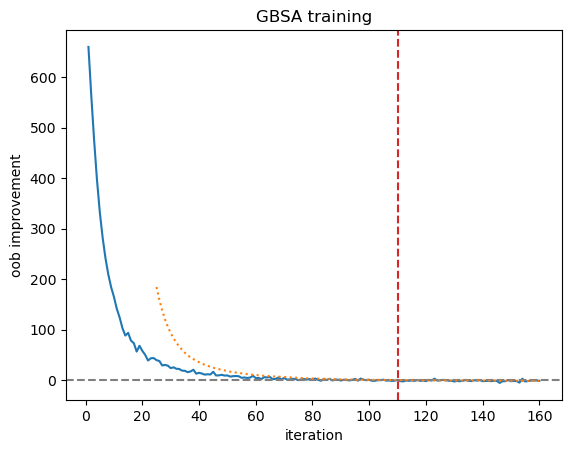

In [30]:
improvement = pd.Series(
    est_early_stopping.oob_improvement_, index=np.arange(1, 1 + len(est_early_stopping.oob_improvement_))
)
ax = improvement.plot(xlabel="iteration", ylabel="oob improvement")
ax.axhline(0.0, linestyle="--", color="gray")
cutoff = len(improvement) - monitor.max_iter_without_improvement
ax.axvline(cutoff, linestyle="--", color="C3")
ax.title.set_text("GBSA training")

_ = improvement.rolling(monitor.window_size).mean().plot(ax=ax, linestyle=":")

In [36]:
evaluate_model(est_early_stopping, X_test, y_test, y_train, times)

Concordance Uno: 0.699
IBS: 0.162
Mean AUC: 0.734


((0.6989670476507215, 103570962, 44944327, 1, 22189),
 0.16236028658964416,
 0.7343062847588523)

In [40]:
import pickle

# pickle_file = 'TrainedModels/GBSA_0.698_lr0.2_deceased_early_stopping.pkl'
# pickle_file = 'TrainedModels/FINAL_GBSA_0.698_lr0.2_deceased_early_stopping.pkl'

# with open(pickle_file, 'wb') as f:
#     pickle.dump(est_early_stopping, f)


In [ ]:
# pickle_file = 'TrainedModels/GBSA_0.698_lr0.2_deceased_early_stopping.pkl'
# pickle_file = 'TrainedModels/FINAL_GBSA_0.698_lr0.2_deceased_early_stopping.pkl'

# with open(pickle_file, 'rb') as f:
#     best_model = pickle.load(f)

Text(0, 0.5, 'time-dependent Brier Score')

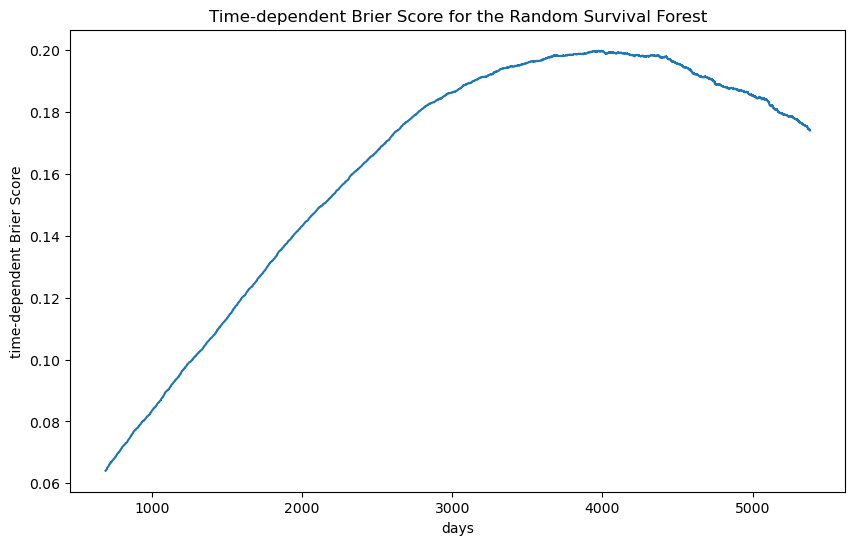

In [37]:
import matplotlib.pyplot as plt
from sksurv.metrics import brier_score

# or best_model
surv_fn = est_early_stopping.predict_survival_function(X_test, return_array=False)

surv_prob = np.row_stack([fn(times) for fn in surv_fn])

bs = brier_score(y_train, y_test, surv_prob, times)

plt.figure(figsize=(10,6))
plt.plot(bs[0], bs[1], marker=",")
# plt.axhline(ibs, linestyle="--")
# plt.text(5, 0, "{model}", fontsize=12)
plt.title("Time-dependent Brier Score for the Random Survival Forest")
plt.xlabel("days")
plt.ylabel("time-dependent Brier Score")

In [42]:
import pickle

with open('pickle/brier/BS_GBSA_DECEASED_FINAL.pickle', 'wb') as f:
    pickle.dump(bs, f)


In [43]:
lower, upper = np.percentile(y_train["Days"], [10, 90])
times = np.arange(lower, upper + 1)
cph_risk_scores = est_early_stopping.predict(X_test)
auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, times)



In [44]:
with open('pickle/AUC/AUC_GBSA_DECEASED_FINAL.pickle', 'wb') as f:
    pickle.dump((times, auc, mean_auc), f)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

from sksurv.metrics import (
    as_concordance_index_ipcw_scorer,
    as_cumulative_dynamic_auc_scorer,
    as_integrated_brier_score_scorer,
)

# Define the parameter grid
param_grid = {'estimator__max_depth': [2, 4, 6, 8, 10]}

# Create the model
estimator = GradientBoostingSurvivalAnalysis(n_estimators=3, learning_rate=0.1, subsample=0.5, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    as_concordance_index_ipcw_scorer(estimator, tau=times[-1]), 
    param_grid, cv=3, verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train[1000:], y_train[1000:])

# Print the best parameters and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters:  {'estimator__max_depth': 6}
Best Score:  0.6799755080022739
